In [1]:
# import modules
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
warnings.filterwarnings('ignore')

## Data Precprocessing 

In [2]:
# assign path
path, dirs, files = next(os.walk('../data/csv'))
file_count = len(files)

# create empty list
dataframes_list = []
# append datasets to the list 
for i in range(file_count):
    temp_df = pd.read_csv(path+'/'+files[i])
    temp_df = temp_df.drop(columns='year')
    
    # Assign a unique pollutant number to each dataset
    # The value of 'i+1' ensures that each dataset is assigned a unique number starting from 1
    temp_df.insert(2, 'Pollutant', i+1) # 
    dataframes_list.append(temp_df)

# Concatenate dataframes into one signle dataframe
df = pd.concat(dataframes_list, ignore_index= True)    

In [3]:
# Standardizing Data
scaler = StandardScaler()

# Apply StandardScaler to each column except the third one (index 2)
for col in df.columns:
    if df.columns.get_loc(col) != 2:  # Checks if the column index is not 2
        df[col] = scaler.fit_transform(df[[col]])   

## Data Exploration & Visualization

In [ ]:
df.isnull().sum()

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
# Check skewness of each column
print(df.skew())

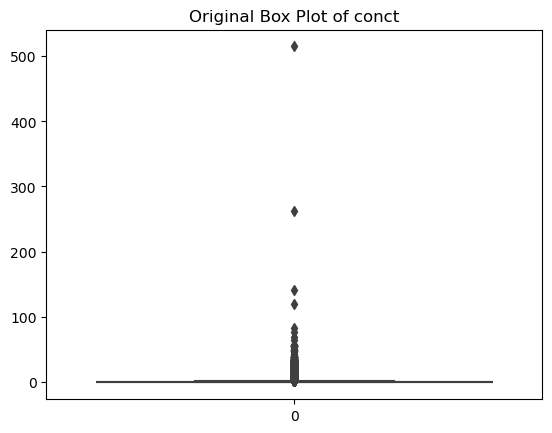

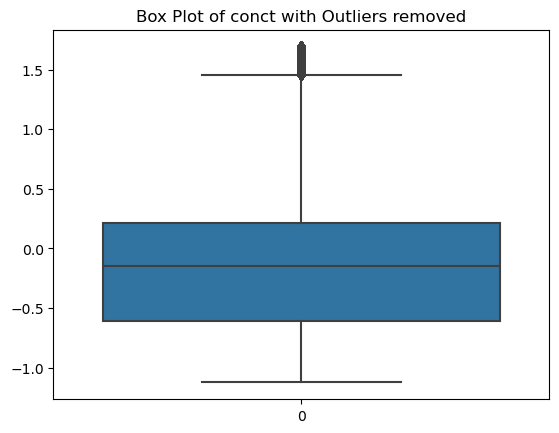

In [4]:
# Function to remove outliers from a specified column using the IQR method
def remove_outliers(df, column):
    # Display the original data distribution in a box plot for visual inspection
    sns.boxplot(df[column])
    plt.title(f'Original Box Plot of {column}')
    plt.show()
    
    # Calculate the IQR which is the difference between 75th and 25th percentiles
    for x in [column]:
        q75,q25 = np.percentile(df.loc[:,x],[75,25])
        intr_qr = q75-q25
        
        # Define the upper and lower bounds for outliers
        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)
    
        # Replace outliers with NaN for later removal
        df.loc[df[x] < min,x] = np.nan
        df.loc[df[x] > max,x] = np.nan
        
    # Remove rows with NaN values in the column to clear out the outliers
    df[column].isnull().sum()
    df = df.dropna()
    
    # Display a box plot of the data column after removing outliers
    sns.boxplot(df[column])
    plt.title(f'Box Plot of {column} with Outliers removed')
    plt.show()
    
    # Return the dataframe with outliers removed
    return df

# Remove outliers from the 'conct' column, presenting many outliers 
df = remove_outliers(df, 'conct')

In [ ]:
''' Generate and display a heatmap of the correlation matrix for dataframe columns 
to visually inspect the pairwise correlations between features'''
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot = True, cmap = 'viridis', 
            fmt = '0.2f', linewidth = 0.5)
plt.title('Correlation Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.xticks(rotation = 45)
plt.show()

In [ ]:
# Plotting Histogram (kde = kernel density)
sns.histplot(df['conct'], kde=True).set(title='Concentrations Histogram')

In [ ]:
''' Create a 3D scatter plot to visualize the relationships between the 'x', 'y', 
and 'conct' variables in the dataset '''
fig = plt.figure(figsize = (20,20))
plt.style.use('classic')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'],df['conct'], c = 'red')
ax.set_xlabel('x', fontsize = 20)
ax.set_ylabel('y', fontsize = 20)
ax.set_zlabel('conct', fontsize = 20)

## Regression Models

In [5]:
X = df.drop(columns='conct').values  #features
y = df['conct']  # Target variable

In [6]:
# using the train test split function 
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=104, test_size=0.25, shuffle=True) 

In [7]:
# Function to evaluate the performance of regression models
def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

# Evaluation metrics
    print(f'TRAINING RESULTS FOR {model}: \n===============================')
    print(f'Mean Absolute Error (MAE) - Training: {mean_absolute_error(y_train, y_train_pred):.4f}')
    print(f'Mean Squared Error (MSE) - Training: {mean_squared_error(y_train, y_train_pred):.4f}')
    print(f'R-squared (R²) Score - Training: {r2_score(y_train, y_train_pred):.4f}')

    print(f'\nTESTING RESULTS FOR {model}: \n===============================')
    print(f'Mean Absolute Error (MAE) - Testing: {mean_absolute_error(y_test, y_test_pred):.4f}')
    print(f'Mean Squared Error (MSE) - Testing: {mean_squared_error(y_test, y_test_pred):.4f}')
    print(f'R-squared (R²) Score - Testing: {r2_score(y_test, y_test_pred):.4f}')

# Predicted vs Actual Density Plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=y_test, y=y_test_pred, cmap="Reds", fill=True)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Density Plot of Actual vs Predicted Values')
    plt.show()

# Residuals Hexbin Plot
    residuals = y_test - y_test_pred
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=y_test_pred, y=residuals, cmap="Purples", fill=True)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Density Residual Plot')
    plt.show()

#### ** Model 1: Decision Tree

In [ ]:
# Train the model on the training dataset
model1 =DecisionTreeRegressor()
model1.fit(X_train, y_train)

# Predict the results for unseen data using the trained model and evaluate performance
evaluate(model1, X_train, X_test, y_train, y_test)

#### Model 2: KNN Regressor

In [ ]:
# Find optimum number of k
rmse_val = []
for k in range(1, 10):
    model2 = KNeighborsRegressor(n_neighbors=k)
    model2.fit(X_train, y_train)
    predictions = model2.predict(X_test)
    error = sqrt(mean_squared_error(y_test, predictions)) # calculate rmse
    rmse_val.append(error) # store rmse values
    print(f'Score for k={k}: {model2.score(X_test, y_test)} \n')

# Print elbow
curve = pd.DataFrame(rmse_val) # elbow curve 
curve.plot()

In [ ]:
# Train the K-NN model on the training dataset
model2 = KNeighborsRegressor(n_neighbors=3)
model2.fit(X_train, y_train)
# Predicting the Test set results
predictions = model2.predict(X_test)

# Predict the results for unseen data using the trained model and evaluate performance
evaluate(model2, X_train, X_test, y_train, y_test)

## NOTE: The models below require significant computational power and time to run. Therefore, we will train them using a random sample of 10,000 rows from the original dataset.

#### Model 3: Support Vector Regressor 

#####   Step 1: Finding the best parameters for the SVR model

In [8]:
sample_df = df.sample(n=10000, random_state=104)
X_sample = sample_df.drop(columns='conct')
y_sample = sample_df['conct']

X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, random_state=104, test_size=0.2, shuffle=True)

In [13]:
# Create an SVR model with an RBF kernel
model3 = SVR(kernel='rbf')

# Define a grid of hyperparameters to search over during cross-validation
param_grid = {
    'C': [0.1, 1, 10, 100],              # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1]  
}

# Perform Grid Search Cross-Validation to find the best combination of hyperparameters
grid_search = GridSearchCV(estimator=model3,    
                           param_grid=param_grid,   
                           cv=5,        
                           scoring='neg_mean_squared_error',  
                           n_jobs=-1)  

# Fit the grid search to the training data
grid_search.fit(X_sample_train, y_sample_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.1, 1]},
             scoring='neg_mean_squared_error')

In [14]:
# Get the best estimator (best SVR model) found by grid search
best_svr = grid_search.best_estimator_
# Use the best SVR model to make predictions on the test data
y_sample_pred = best_svr.predict(X_sample_test)
# Calculate the Mean Squared Error (MSE) 
mse = mean_squared_error(y_sample_test, y_sample_pred)

print("Mean Squared Error:", mse)
print("Best Parameters:", grid_search.best_params_)

Mean Squared Error: 0.024332894926209155
Best Parameters: {'C': 100, 'gamma': 1}


#### Step 2: Build the SVR model using the best paramters

TRAINING RESULTS FOR SVR(C=100, gamma=1): 
Mean Absolute Error (MAE) - Training: 0.0902
Mean Squared Error (MSE) - Training: 0.0243
R-squared (R²) Score - Training: 0.9396

TESTING RESULTS FOR SVR(C=100, gamma=1): 
Mean Absolute Error (MAE) - Testing: 0.0931
Mean Squared Error (MSE) - Testing: 0.0243
R-squared (R²) Score - Testing: 0.9397


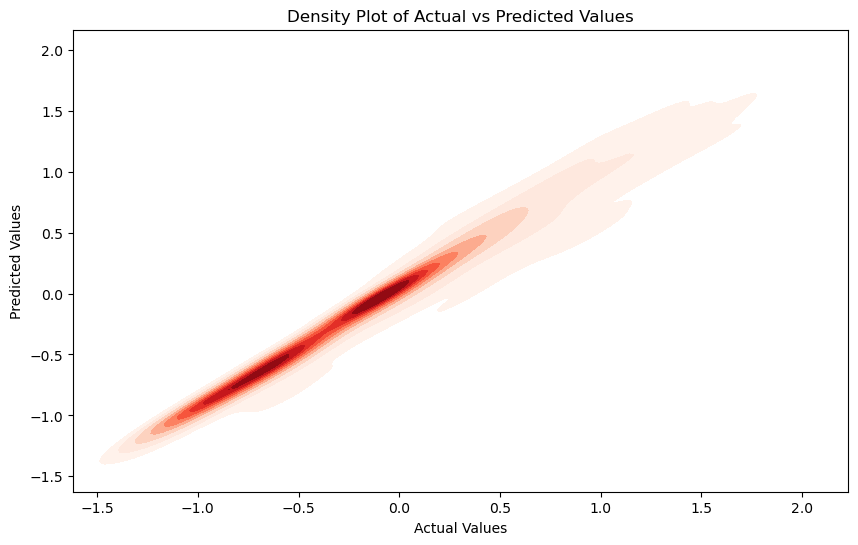

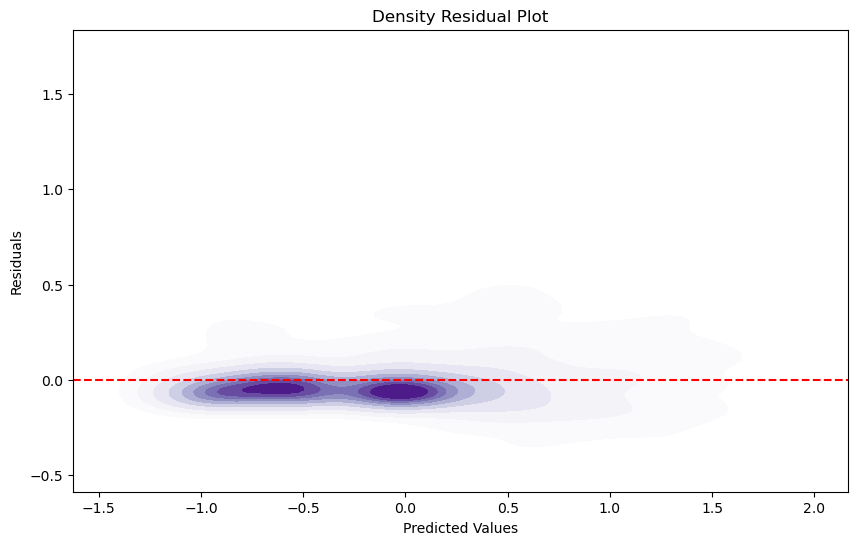

In [15]:
# Train the SVR model on the training dataset
svr = SVR(kernel='rbf', C=100, gamma=1)
svr.fit(X_sample_train, y_sample_train)
# Predict the results for unseen data using the trained model and evaluate performance
evaluate(svr, X_sample_train, X_sample_test, y_sample_train, y_sample_test)

#### Model 4: Bagging Regressor

In [ ]:
'''# Create a DecisionTreeRegressor as the base estimator
tree = DecisionTreeRegressor()
# Create a BaggingRegressor ensemble model using DecisionTreeRegressor as the base estimator
model4 = BaggingRegressor(base_estimator=tree, n_estimators=10, random_state=42)
# Train the Bagging Regressor model on the training dataset
model4.fit(X_train, y_train)

# Predict the results for unseen data using the trained model and evaluate performance
evaluate(model4, X_train, X_test, y_train, y_test)'''

#### Model 5: Random Forest Reggressor

In [ ]:
'''# Train the Random Forest Regressor model on the training dataset
model5 = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
model5.fit(X_train, y_train)

# Predict the results for unseen data using the trained model and evaluate performance
evaluate(model5, X_train, X_test, y_train, y_test)'''